In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset , DataLoader
import pandas as pd

import os

from transformers import BertTokenizer

from transformers import default_data_collator

# **seed 고정**

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# **Hugging face dateset가져오기**

In [ ]:
# Hugging Face datasets 라이브러리 설치 (설치되지 않은 경우)
!pip install datasets

# GLUE 데이터셋 불러오기
from datasets import load_dataset

# MRPC (Microsoft Research Paraphrase Corpus) 태스크 로드 예시
dataset = load_dataset("glue", "mrpc")

In [ ]:
# 데이터셋 정보 출력
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})


sentence1 , sentence2의 동의어 관계 판별 ,

---
label : 1 -> 동의어 관계
label : 0 -> 동의어 관계 아님

---
idx : 고유 id



In [ ]:
# 훈련, 검증 데이터 예시 출력
print(f"Train Example: {dataset['train'][0]}")
print(f"Validation Example: {dataset['validation'][0]}")

Train Example: {'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .', 'label': 1, 'idx': 0}
Validation Example: {'sentence1': "He said the foodservice pie business doesn 't fit the company 's long-term growth strategy .", 'sentence2': '" The foodservice pie business does not fit our long-term growth strategy .', 'label': 1, 'idx': 9}


# **데이터 시각화**

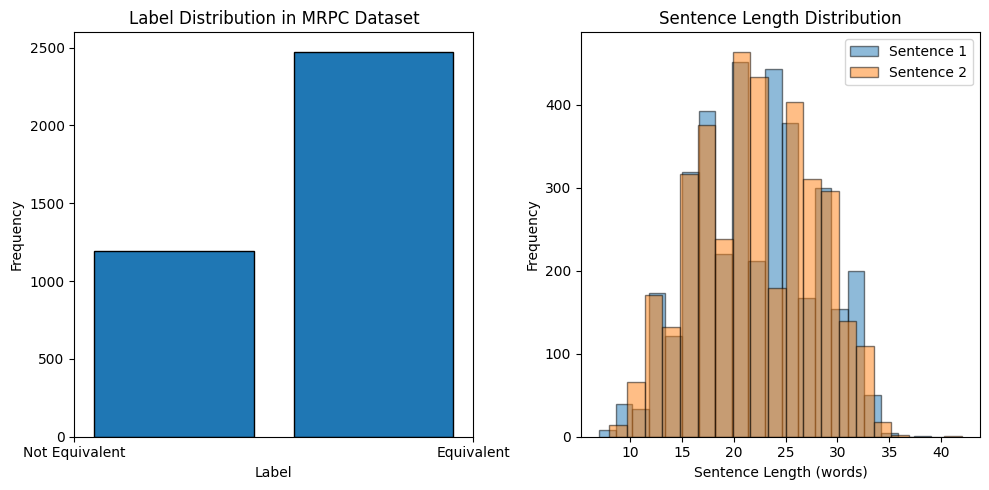

In [ ]:
# 레이블과 문장 길이 계산
visualize_dataset = load_dataset("glue", "mrpc", split="train")
visualize_labels = visualize_dataset["label"]
sentence1_lengths = [len(visualize_sent.split()) for visualize_sent in visualize_dataset["sentence1"]]
sentence2_lengths = [len(visualize_sent.split()) for visualize_sent in visualize_dataset["sentence2"]]

# 레이블 분포 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(visualize_labels, bins=2, edgecolor='black', rwidth=0.8)
plt.xticks([0, 1], ["Not Equivalent", "Equivalent"])
plt.title("Label Distribution in MRPC Dataset")
plt.xlabel("Label")
plt.ylabel("Frequency")

# 문장 길이 분포 시각화
plt.subplot(1, 2, 2)
plt.hist(sentence1_lengths, bins=20, alpha=0.5, label="Sentence 1", edgecolor='black')
plt.hist(sentence2_lengths, bins=20, alpha=0.5, label="Sentence 2", edgecolor='black')
plt.legend(loc="upper right")
plt.title("Sentence Length Distribution")
plt.xlabel("Sentence Length (words)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Label distribution in MRPC Dataset -> not equivalent와 equivalent class mismatch가 대략 2배 -> weight sampling 필요

---
Sentence length distribution을 보면 대략 max(sentence length) < 50, max_length = 64로 한다


# **토큰화**

In [ ]:
# 2. BERT 토크나이저 불러오기 (사전 학습된 BERT 모델 사용)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# 3. 토큰화 함수 정의
def tokenize_function(examples):
    # sentence1과 sentence2를 함께 토큰화 (Padding, Truncation 처리)
    return tokenizer(examples["sentence1"],
                     examples["sentence2"],
                     padding="max_length",
                     truncation=True,
                     max_length=64)

In [ ]:
# 4. 데이터셋에 토큰화 적용
tokenized_dataset = dataset.map(tokenize_function, batched=True)

In [ ]:
# 5. 토큰화된 데이터 예시 출력
print(tokenized_dataset["train"][0])

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .', 'label': 1, 'idx': 0, 'input_ids': [101, 2572, 3217, 5831, 5496, 2010, 2567, 1010, 3183, 2002, 2170, 1000, 1996, 7409, 1000, 1010, 1997, 9969, 4487, 23809, 3436, 2010, 3350, 1012, 102, 7727, 2000, 2032, 2004, 2069, 1000, 1996, 7409, 1000, 1010, 2572, 3217, 5831, 5496, 2010, 2567, 1997, 9969, 4487, 23809, 3436, 2010, 3350, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

구조 :

---

(sentence1 원문 , sentence2 원문 , label , idx , input_ids1 & 2 , token_type_ids , attention_mask)

---
token_type_ids : 두 문장(문장1, 문장2)을 구분하기 위한 인코딩 (BERT에서 사용),

---

attention_mask : 패딩된 부분을 무시하도록 마스킹 처리 (1은 유효한 토큰, 0은 패딩)


# **배치화**

In [ ]:
# 데이터셋을 DataLoader에 넣기
train_loader = DataLoader(tokenized_dataset["train"], batch_size=256, collate_fn=default_data_collator)

In [ ]:
# 3. 배치 반복 및 크기 확인
for batch in train_loader:
    print(batch.keys())  # 딕셔너리의 키 확인 (예: input_ids, attention_mask, label)

    input_ids = batch['input_ids']
    print(f"Input IDs shape: {len(input_ids)}")
    print(f"Input IDs shape: {len(input_ids[0])}")

    attention_mask = batch['attention_mask']
    print(f"Attention Mask shape: {len(attention_mask)}")
    print(f"Attention Mask shape: {len(attention_mask[0])}")
    break  # 첫 배치만 확인

dict_keys(['labels', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'])
Input IDs shape: 256
Input IDs shape: 64
Attention Mask shape: 256
Attention Mask shape: 64


# **필드 추출**

In [ ]:
# 5. DataLoader에서 배치 추출 및 Encoder에 입력 예시
for batch in train_loader:
    # 필요한 텐서 추출
    input_ids = batch['input_ids']
    # 어디 문장 소속인지 여부를 표시하는 텐서 추가
    token_type_ids = batch['token_type_ids']
    attention_mask = batch['attention_mask']
    label = batch['labels']

    print(f"Batch size: {len(input_ids)}, Sequence length: {len(input_ids[0])}")
    print(f"label : {len(label)}")

Batch size: 256, Sequence length: 64
label : 256
Batch size: 256, Sequence length: 64
label : 256
Batch size: 256, Sequence length: 64
label : 256
Batch size: 256, Sequence length: 64
label : 256
Batch size: 256, Sequence length: 64
label : 256
Batch size: 256, Sequence length: 64
label : 256
Batch size: 256, Sequence length: 64
label : 256
Batch size: 256, Sequence length: 64
label : 256
Batch size: 256, Sequence length: 64
label : 256
Batch size: 256, Sequence length: 64
label : 256
Batch size: 256, Sequence length: 64
label : 256
Batch size: 256, Sequence length: 64
label : 256
Batch size: 256, Sequence length: 64
label : 256
Batch size: 256, Sequence length: 64
label : 256
Batch size: 84, Sequence length: 64
label : 84


# **데이터 처리**

In [ ]:
# batch는 dictionary 형태이므로 필요한 필드만 따로 추출해야한다
# token embeddings + segment embeddings + positional embeddings + attention_mask

# **Encoder**

# **hyperparameter**

In [ ]:
num_heads = 8
embedding_dim = 64 * num_heads

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads , embedding_dim , input_size = 16):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.num_heads = num_heads
    self.head_dim = embedding_dim // num_heads
    #self.input_size = input_size

    self.q = nn.Linear(embedding_dim , embedding_dim)
    self.k = nn.Linear(embedding_dim , embedding_dim)
    self.v = nn.Linear(embedding_dim , embedding_dim)

    self.fc = nn.Linear(embedding_dim , embedding_dim)

  def go(self , x):

    batch_size = x.shape[0]

    q = self.q(x) # batch_num , sequence_length , embed_size : 16 , 16 , 128
    k = self.k(x)
    v = self.v(x)

    q = q.view(batch_size , -1 , self.num_heads , self.head_dim).transpose(1,2) # batch , num_head, 16 , 16*8//8 = 16
    k = k.view(batch_size , -1 , self.num_heads , self.head_dim).transpose(1,2)
    v = v.view(batch_size , -1 , self.num_heads , self.head_dim).transpose(1,2)

    # Scaled Dot-Product Attention
    attention_score = (q @ k.transpose(3,2)) / (self.head_dim ** 0.5)
    attention_score = torch.softmax(attention_score, dim=-1)
    attention = torch.matmul(attention_score , v)
    attention = attention.transpose(1,2).contiguous().view(batch_size , -1 , self.embedding_dim) # batch , 8 , sequence_length , 16*8//8 = 16
    attention = attention.reshape(x.shape[0] , x.shape[1] , x.shape[2])
    output = self.fc(attention)

    return output # batch , sequence_length , 16*8

# **인풋의 길이, max_length = 64로 두고 padding처리한다**

In [ ]:
class Pre_process(nn.Module):
    def __init__(self ,num_heads , embedding_dim , vocab_size = 40000 , max_length = 64, dropout=0.1):
        super().__init__()
        self.embed_size = embedding_dim
        self.max_length = max_length
        self.word_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Parameter(torch.randn(1 , max_length , embedding_dim))
        self.dropout = nn.Dropout(dropout)
    def run(self , input , token_type_ids , attention_mask):
        batch_num , seq_length = input.shape
        z = self.word_embedding(input) # z.shape : batch_num , sequence_length , embedding_dim
        positional_embed = self.position_embedding.expand(batch_num , self.max_length , self.embed_size)
        # 단어 임베딩 + position + 문장 소속(binary)
        out = z + positional_embed + token_type_ids.unsqueeze(2).expand(batch_num,self.max_length,self.embed_size) + attention_mask.unsqueeze(2).expand(batch_num,self.max_length,self.embed_size)
        out = self.dropout(out)
        return out # out.shape : batch_num , sequence_length , embed_size

x -> Encoder -> y -> multiheadattention -> z -> Encoder_block

# **Encoder block**

In [ ]:
class Encoder_Block(nn.Module):
  def __init__(self, num_heads , embed_size , dropout = 0.1):
    super().__init__()

    self.relu = nn.ReLU()

    self.norm1 = nn.LayerNorm(embed_size)
    self.norm2 = nn.LayerNorm(1)

    self.l1 = nn.Linear(embed_size , embed_size)
    self.l2 = nn.Linear(embed_size , 1)
    self.l3 = nn.Linear(64 , 1)

    self.pre_process = Pre_process(num_heads , embed_size)
    self.attention = MultiHeadAttention(num_heads , embed_size)

    self.dropout = nn.Dropout(0.1)

  def update(self , input , token_type_ids , attention_mask):

    c = self.pre_process.run(input , token_type_ids , attention_mask)
    z = self.attention.go(c)

    z = z + c
    # print(z.shape) , [16, 16, 128]
    z1 = self.norm1(z)

    z = self.l1(z1)
    z = self.relu(z)

    #skip
    z = z1 + z  # z.shape : 16 ,16 , 128

    z = self.l2(z) # 16 ,16 , 1
    z = z.reshape(z.shape[0] , z.shape[1])
    z = self.l3(z) # 16 , 1

    z = self.norm2(z) # 16 , 1

    return z # 16 , 1

Model 설계

In [ ]:
model = Encoder_Block(num_heads , embedding_dim)

# **아키텍쳐**

In [ ]:
#model = model.to(device)
optimizer =  torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
cnt = 0
loss_history = []
test_loss_history = []
bce_loss = nn.BCEWithLogitsLoss()

epochs = 100

model.train()
for epoch in range(epochs):
  for batch in train_loader:

    # 필요한 텐서 추출
    input_ids = batch['input_ids']
    #input_ids = torch.stack(input_ids)

    # 어디 문장 소속인지 여부를 표시하는 텐서 추가
    token_type_ids = batch['token_type_ids']
    #token_type_ids = torch.stack(token_type_ids)

    #attention_mask
    attention_mask = batch['attention_mask']

    #label
    labels = batch['labels'].unsqueeze(1)

    #print(model.device)
    output = model.update(input_ids , token_type_ids , attention_mask)

    # class mismatch 해결 위해 weight sampling 적용
    pos_weight = torch.tensor([0.5])
    # BCEWithLogitsLoss 설정
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    loss = criterion(output, labels.float())

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss history append
    loss_history.append(loss.item())

  #scheduler_linear.step()
  print("epoch : {} , loss : {}".format(epoch, loss))

epoch : 0 , loss : 0.44122740626335144
epoch : 1 , loss : 0.44016534090042114
epoch : 2 , loss : 0.4396933913230896
epoch : 3 , loss : 0.43961256742477417
epoch : 4 , loss : 0.43965771794319153
epoch : 5 , loss : 0.43970027565956116
epoch : 6 , loss : 0.4397154748439789
epoch : 7 , loss : 0.43971532583236694
epoch : 8 , loss : 0.4397120773792267
epoch : 9 , loss : 0.4397100806236267
epoch : 10 , loss : 0.4397095739841461
epoch : 11 , loss : 0.4397096037864685
epoch : 12 , loss : 0.43970975279808044
epoch : 13 , loss : 0.43970975279808044
epoch : 14 , loss : 0.4397096633911133
epoch : 15 , loss : 0.4397096037864685
epoch : 16 , loss : 0.43970951437950134
epoch : 17 , loss : 0.43970951437950134
epoch : 18 , loss : 0.4397094249725342
epoch : 19 , loss : 0.4397094249725342
epoch : 20 , loss : 0.4397094249725342
epoch : 21 , loss : 0.439709335565567
epoch : 22 , loss : 0.4397094249725342
epoch : 23 , loss : 0.43970930576324463
epoch : 24 , loss : 0.43970930576324463
epoch : 25 , loss : 0.43

초기 , num_heads = 8 , lr = 0.001

---


epoch99 : 0.594

learning_rate from 0.001 to 0.01

---
epcoh99 : 0.592


loss 0.592에서 잘 떨어지지 않는다

In [ ]:
!pip install evaluate

In [ ]:
#평가
import evaluate
metric = evaluate.load("glue", "mrpc")
model.eval()
test_loader = DataLoader(tokenized_dataset["test"], batch_size=len(tokenized_dataset["test"]), collate_fn=default_data_collator)
for batch in test_loader:
    input = batch['input_ids']
    token = batch['token_type_ids']
    mask = batch['attention_mask']
    print(input.shape)
    print(token.shape)
    print(mask.shape)
    with torch.no_grad():
        outputs = model.update(input , token , mask)

    predictions = torch.sigmoid(outputs) > 0.5
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

torch.Size([1725, 64])
torch.Size([1725, 64])
torch.Size([1725, 64])


{'accuracy': 0.664927536231884, 'f1': 0.7987465181058496}